# Two Stage Robust Optimization with CCG Algorithm

In [1]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

In [5]:
class CCG_toy:
    def __init__(self):
        self.f = np.array([400,414,326])
        self.a = np.array([18,25,20])
        self.c = np.array([[22,33,24],
                            [33,23,30],
                            [20,25,27]])
        self.capacity = 800
        self.init_d = np.array([206,274,220])
        self.n = self.c.shape[0]
        self.m = self.c.shape[1]

        self.UB = float("inf")
        self.LB = float("-inf")
        self.M = 1e5
        self.epsilon = 1e-5
        self.k = 0
        self.lb_set = []
        self.ub_set = []
        self.initialize_model()

    def initialize_model(self):
        
        # Master problem
        self.MP = gp.Model("CC&G Master")
        self.y = self.MP.addVars(range(self.n), vtype=gp.GRB.BINARY, name="y")
        self.z = self.MP.addVars(range(self.n), lb=0, vtype=gp.GRB.CONTINUOUS, name="z")
        self.x_SP = self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name="x_SP")
        self.yita = self.MP.addVar(vtype=gp.GRB.CONTINUOUS, name="yita")
        
        self.MP_Obj = gp.quicksum(self.f[i] * self.y[i] + self.a[i] * self.z[i] for i in range(self.n))
        self.MP_Obj = self.MP_Obj + self.yita
        self.MP.setObjective(self.MP_Obj, gp.GRB.MINIMIZE)
        
        self.MP.addConstrs((self.z[i] <= self.capacity*self.y[i] for i in range(self.n)), "z(i) <= 800*y(i)")
        self.MP.addConstr(sum(self.z[i] for i in range(self.n)) >= 772, "sum_z >= 772")
        for i in range(self.n):
            row_sum_x = sum(self.x_SP[i,j] for j in range(self.m))
            self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
        for j in range(self.m):
            col_sum_x = sum(self.x_SP[i,j] for i in range(self.n))
            self.MP.addConstr(col_sum_x >= self.init_d[j], name=f"sum_x_{j} >= opt_d{j}")
        
        # Adversarial problem
        self.SP = gp.Model("CC&G Sub")
        self.x = self.SP.addVars(range(self.n), range(self.m), lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="x")
        self.g = self.SP.addVars(range(self.n), lb=0, ub=1, vtype=gp.GRB.CONTINUOUS, name="g")
        self.d = self.SP.addVars(range(self.m), lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="d")
        
        self.SP.addConstrs(self.d[j] == self.init_d[j] + 40 * self.g[j] for j in range(self.m))
        self.SP.addConstr(sum(self.g[i] for i in range(self.n)) <= 3)
        self.SP.addConstr(sum(self.g[i] for i in range(self.n)) <= 1.8)
        self.SP.addConstr(self.g[0] + self.g[1] <= 1.2)

    def optimize(self):
        while (self.UB - self.LB > self.epsilon):
            
            print("Iteration",self.k)
            print("Upper bound:",self.UB)
            print("Lower bound:",self.LB)
            print("---------------------")
            print(f"       MP {self.k}          ")
            print("---------------------")
            
            # Solve the master problem
            self.MP.optimize()
            # Get the optimal value of z
            z_opt = np.array([self.z[i].X for i in range(self.n)])
            # Update the lower bound
            self.LB = max(self.LB,self.MP.objVal)
            self.lb_set.append(self.LB)
            if self.k > 0:
                self.SP.remove(sp1)
                self.SP.remove(sp2)
                self.SP.remove(sp3)
                self.SP.remove(sp4)
                self.SP.remove(sp5)
                self.SP.remove(sp6)
                self.SP.remove(sp7)
                self.SP.remove(sp8)
                self.SP.remove(sp9)
                self.SP.remove(v)
                self.SP.remove(w)
                self.SP.remove(pi)
                self.SP.remove(h)
                self.SP.update()

            # KKT constraints
            pi = self.SP.addVars(range(self.n), lb=-gp.GRB.INFINITY, ub=0, vtype=gp.GRB.CONTINUOUS, name="pi")
            theta = self.SP.addVars(range(self.m), lb=-gp.GRB.INFINITY, ub=0, vtype=gp.GRB.CONTINUOUS, name="theta")
            v = self.SP.addVars(range(self.n), vtype=gp.GRB.BINARY, name="v")
            w = self.SP.addVars(range(self.m), vtype=gp.GRB.BINARY, name="w")
            h = self.SP.addVars(range(self.n), range(self.m), vtype=gp.GRB.BINARY, name="h")
            
            sp1 = self.SP.addConstrs(sum(self.x[i,j] for j in range(self.m)) <= z_opt[i] for i in range(self.n))
            sp2 = self.SP.addConstrs(sum(self.x[i,j] for i in range(self.n)) >= self.d[j] for j in range(self.m))
            sp3 = self.SP.addConstrs(pi[i] - theta[j] <= self.c[i][j] for i in range(self.n) for j in range(self.m))
            sp4 = self.SP.addConstrs(-pi[i] <= self.M*v[i] for i in range(self.n))
            sp5 = self.SP.addConstrs(z_opt[i] - sum(self.x[i,j] for j in range(self.m)) <= self.M*(1-v[i]) for i in range(self.n) for j in range(self.m))
            sp6 = self.SP.addConstrs(-theta[j] <= self.M*w[j] for j in range(self.m))
            sp7 = self.SP.addConstrs(sum(self.x[i,j] for i in range(self.n)) - self.d[j] <= self.M*(1-w[j]) for j in range(self.m))
            sp8 = self.SP.addConstrs(self.x[i,j] <= self.M*h[i,j] for i in range(self.n) for j in range(self.m))
            sp9 = self.SP.addConstrs(self.c[i][j] - pi[i] + theta[j] <= self.M*(1-h[i,j]) for i in range(self.n) for j in range(self.m))
                
            SP_Obj = sum(self.c[i][j]*self.x[i,j] for i in range(self.n) for j in range(self.m))
            self.SP.setObjective(SP_Obj, gp.GRB.MAXIMIZE)
            
            print("---------------------")
            print(f"       SP {self.k}          ")
            print("---------------------")
            
            self.SP.optimize()
            
            
            if self.SP.Status != gp.GRB.INFEASIBLE:
                opt_d = np.array([self.d[j].X for j in range(self.m)])
                y_stage1 = np.array([self.y[i].X for i in range(self.n)])
                z_stage1 = np.array([self.z[i].X for i in range(self.n)])
                
            if self.SP.status == gp.GRB.OPTIMAL:
                # Update the upper bound
                self.UB = min(self.UB,self.SP.ObjVal + sum(self.f[i]*y_stage1[i] + self.a[i]*z_stage1[i] for i in range(self.n)))
                self.ub_set.append(self.UB)
                
                var_name = f'x{self.k}'
                new_x = self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name=var_name)
                
                sum_cx = 0
                for i in range(self.n):
                    for j in range(self.m):
                        sum_cx += self.c[i,j]*new_x[i,j]
                self.MP.addConstr(self.yita >= sum_cx, name="yita >= sum_cx")
                
                for i in range(self.n):
                    row_sum_x = sum(new_x[i,j] for j in range(self.m))
                    self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
                
                for j in range(self.m):
                    col_sum_x = sum(new_x[i,j] for i in range(self.n))
                    self.MP.addConstr(col_sum_x >= opt_d[j], name=f"sum_x_{j} >= opt_d{j}")
                
                self.MP.update()
                
            elif self.SP.Status == gp.GRB.UNBOUNDED:
                # Update the upper bound
                self.UB = min(self.UB,self.SP.ObjVal)
                self.ub_set.append(self.UB)
                
                var_name = f'x{self.k}'
                self.MP.addVars(range(self.n), range(self.m), lb=0, vtype=gp.GRB.CONTINUOUS, name=var_name)
                
                for i in range(self.n):
                    row_sum_x = sum(new_x[i,j] for j in range(self.m))
                    self.MP.addConstr(row_sum_x <= self.z[i], name=f"sum_x_{i} <= z{i}")
                
                for j in range(self.m):
                    col_sum_x = sum(new_x[i,j] for i in range(self.n))
                    self.MP.addConstr(col_sum_x >= opt_d[j], name=f"sum_x_{j} >= opt_d{j}")
            
            else:
                print("No solution due to infeasibility")
                break
        
            self.k = self.k + 1
            if self.k > 10:
                break

        print("")
        print("-------------------------")
        print("-------------------------")
        print("求解结束")
        print("上界：",self.UB)
        print("下界：",self.LB)
        print("迭代次数：",self.k)
        plt.figure()
        plt.plot(range(self.k), self.lb_set, label="lower bound")
        plt.plot(range(self.k), self.ub_set, label="upper bound")
        plt.xlabel("iteration")
        plt.ylabel("value")
        plt.legend()
        plt.show()



Iteration 0
Upper bound: inf
Lower bound: -inf
---------------------
       MP 0          
---------------------
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i7-7800X CPU @ 3.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10 rows, 16 columns and 30 nonzeros
Model fingerprint: 0x16b6822c
Variable types: 13 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [1e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 8e+02]
Presolve removed 3 rows and 4 columns
Presolve time: 0.00s
Presolved: 7 rows, 12 columns, 30 nonzeros
Variable types: 9 continuous, 3 integer (3 binary)
Found heuristic solution: objective 14296.000000

Root relaxation: objective 1.428200e+04, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Obj

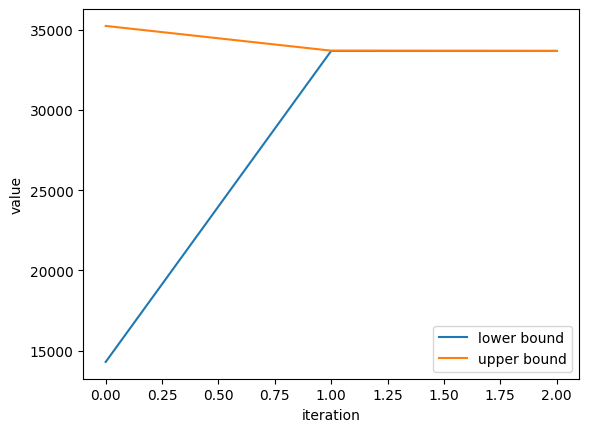

In [6]:
ccg = CCG_toy()
ccg.optimize()

Iteration 0: UB=inf, LB=-inf
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i7-7800X CPU @ 3.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 22 rows, 16 columns and 36 nonzeros
Model fingerprint: 0x89fb075c
Variable types: 13 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [1e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 7e+02]
Presolve removed 22 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 18402 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.840200000000e+04, best bound 1.840200000000e+04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2

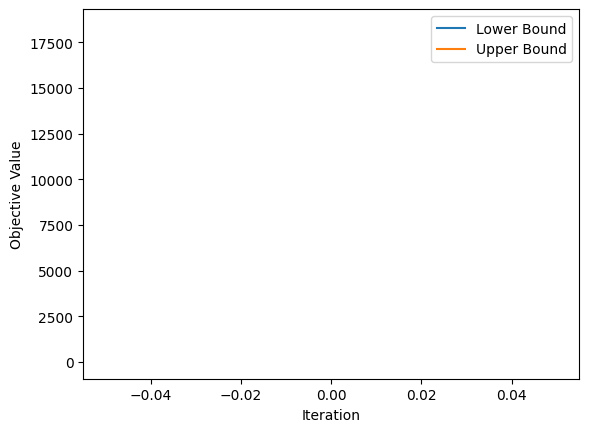

In [5]:
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt

class ColumnConstraintGeneration:
    def __init__(self, f, a, c, d_base, capacity=800, epsilon=1e-5, max_iter=10):
        self.f = np.array(f)
        self.a = np.array(a)
        self.c = np.array(c)
        self.d_base = np.array(d_base)
        self.capacity = capacity
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.n = len(f)  # Number of warehouses
        
        self.UB = float("inf")
        self.LB = float("-inf")
        self.M = 1e5
        self.k = 0
        self.lb_set = []
        self.ub_set = []

        self.initialize_models()

    def initialize_models(self):
        # Initialize Master Problem (MP)
        self.MP = gp.Model("CC&G Master Problem")
        self.y = self.MP.addVars(self.n, vtype=gp.GRB.BINARY, name="y")
        self.z = self.MP.addVars(self.n, lb=0, vtype=gp.GRB.CONTINUOUS, name="z")
        self.x_SP = self.MP.addVars(self.n, self.n, lb=0, vtype=gp.GRB.CONTINUOUS, name="x_SP")
        self.yita = self.MP.addVar(vtype=gp.GRB.CONTINUOUS, name="yita")

        # Objective
        self.MP_Obj = gp.quicksum(self.f[i] * self.y[i] + self.a[i] * self.z[i] for i in range(self.n))
        self.MP_Obj += self.yita
        self.MP.setObjective(self.MP_Obj, gp.GRB.MINIMIZE)

        # Constraints
        self.MP.addConstrs((self.z[i] <= self.capacity * self.y[i] for i in range(self.n)), "Capacity")
        self.MP.addConstr(gp.quicksum(self.z[i] for i in range(self.n)) >= np.sum(self.d_base), "DemandFulfill")
        self.MP.addConstrs((self.x_SP[i, j] <= self.z[i] for i in range(self.n) for j in range(self.n)), "x_SP <= z")
        self.MP.addConstrs((self.x_SP[i, j] >= self.d_base[j] for i in range(self.n) for j in range(self.n)), "x_SP >= d")


        # Initialize Subproblem (SP)
        self.SP = gp.Model("CC&G Subproblem")
        self.x = self.SP.addVars(self.n, self.n, lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="x")
        # Uncertain set
        self.g = self.SP.addVars(self.n, lb=0, ub=1, vtype=gp.GRB.CONTINUOUS, name="g")
        self.d = self.SP.addVars(self.n, lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="d")

        for i in range(self.n):
            self.SP.addConstr(self.d[i] == self.d_base[i] + 40 * self.g[i], name=f"demand_variation_{i}")
        self.SP.addConstr(gp.quicksum(self.g[i] for i in range(self.n)) <= self.n, "g_total_variation")
        self.SP.addConstrs((self.g[i] <= 1.8 for i in range(self.n)), "g_max_variation")
        self.SP.addConstrs((self.g[i] <= 1.2 for i in range(self.n-1)), "g_max_variation")

    def optimize(self):
        while (self.UB - self.LB > self.epsilon) and (self.k < self.max_iter):
            print(f"Iteration {self.k}: UB={self.UB}, LB={self.LB}")
            self.solve_master()
            self.solve_subproblem()

            if self.k > 10:
                break

            self.k += 1

        print(f"Optimization completed with UB={self.UB} and LB={self.LB} after {self.k} iterations.")

    def solve_master(self):
        self.MP.optimize()
        z_opt = np.array([self.z[i].X for i in range(self.n)])
        self.LB = max(self.LB, self.MP.objVal)
        self.lb_set.append(self.LB)

        # Add or adjust subproblem constraints here based on new master problem solution

    def solve_subproblem(self):
        self.SP.optimize()
        if self.SP.status == gp.GRB.OPTIMAL:
            self.UB = min(self.UB, self.SP.objVal)
            self.ub_set.append(self.UB)
            # Update master problem with new cuts or constraints
        elif self.SP.status == gp.GRB.UNBOUNDED:
            # Handle unbounded case
            pass

    def plot_results(self):
        plt.figure()
        plt.plot(range(self.k), self.lb_set, label="Lower Bound")
        plt.plot(range(self.k), self.ub_set, label="Upper Bound")
        plt.xlabel("Iteration")
        plt.ylabel("Objective Value")
        plt.legend()
        plt.show()

# Example usage
f = [400, 414, 326]
a = [18, 25, 20]
c = [[22, 33, 24], [33, 23, 30], [20, 25, 27]]
d_base = [206, 274, 220]

ccg = ColumnConstraintGeneration(f, a, c, d_base)
ccg.optimize()
ccg.plot_results()
